In [2]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import math

from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import CountVectorizer
from sklearn import linear_model

from sklearn.feature_selection import RFE
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import make_scorer, r2_score, mean_squared_error, auc, mean_absolute_error
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV


import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics



# 1. Data Cleaning

As we do data cleaning, we go through all the 50 questions in 394 columns one by one and handle different variables with different methods. 

### Import original data

In [3]:
Salary = pd.read_csv('Kaggle_Salary.csv',low_memory=False)[1:].set_index('index')

After we overview all data, we find that columns like "Unnamed: 0" shows unrelevant information to our task, so we delete them.

Also, the titles of questions and column values like "Time from Start to Finish", "Q1" are duplicate identifiers of features, so we delete them. They are also very long to handle with.

In [4]:
#remove Unnamed:0 
Salary.drop(columns='Unnamed: 0',inplace=True)
print(Salary.shape)
Salary.head(5)

(15429, 395)


Time from Start to Finish (seconds)      Q1 Q1_OTHER_TEXT     Q2  \
index                                                                    
0.0                                   434    Male            -1  30-34   
1.0                                   718  Female            -1  30-34   
2.0                                   731    Male            -1  22-24   
3.0                                   959    Male            -1  35-39   
4.0                                  1758    Male            -1  18-21   

                             Q3                 Q4  \
index                                                
0.0                   Indonesia  Bachelor’s degree   
1.0    United States of America    Master’s degree   
2.0                       India    Master’s degree   
3.0                       Chile    Doctoral degree   
4.0                       India    Master’s degree   

                                                      Q5              Q6  \
index                                                                      
0.0                   Engineering (non-computer focused)           Other   
1.0        Computer science (software engineering, etc.)  Data Scientist   
2.0                            Mathematics or statistics    Data Analyst   
3.0    Information technology, networking, or system ...           Other   
4.0    Information technology, networking, or system ...           Other   

      Q6_OTHER_TEXT                         Q7      ...       Q49_OTHER_TEXT  \
index                                               ...                        
0.0               0  Manufacturing/Fabrication      ...                   -1   
1.0              -1             I am a student      ...                   -1   
2.0              -1             I am a student      ...                   -1   
3.0               1        Academics/Education      ...                   -1   
4.0               2                      Other      ...                   -1   

          Q50_Part_1          Q50_Part_2 Q50_Part_3 Q50_Part_4  \
index                                                            
0.0              NaN                 NaN        NaN        NaN   
1.0              NaN  Too time-consuming        NaN        NaN   
2.0              NaN  Too time-consuming        NaN        NaN   
3.0    Too expensive                 NaN        NaN        NaN   
4.0              NaN                 NaN        NaN        NaN   

                                   Q50_Part_5  \
index                                           
0.0                                       NaN   
1.0                                       NaN   
2.0    Not enough incentives to share my work   
3.0                                       NaN   
4.0    Not enough incentives to share my work   

                                              Q50_Part_6 Q50_Part_7  \
index                                                                 
0.0                                                  NaN        NaN   
1.0                                                  NaN        NaN   
2.0                                                  NaN        NaN   
3.0    I had never considered making my work easier f...        NaN   
4.0                                                  NaN        NaN   

      Q50_Part_8 Q50_OTHER_TEXT  
index                            
0.0          NaN             -1  
1.0          NaN             -1  
2.0          NaN             -1  
3.0          NaN             -1  
4.0          NaN             -1  

[5 rows x 395 columns]

###  Handle missing values

There are several approaches to handle missing values based on the percentage of missing values in each column,

Approach 1: If the percentage of missing values in the column is less than 1%, we choose to delete the rows since since we have a total of 15429 observations which is large enough and 1% is a truly mini percentage.

In [5]:
# We search the columns that have NaN values more than 0% but fewer that 1% of all data
less_than_1_percent = []
for col in Salary.columns:
    NaNcount = Salary[col].isnull().sum()
    if (NaNcount > 0) & (0.01 * Salary.shape[0] > NaNcount):
        if ("Part" not in col) or (col in ['Q39_Part_1','Q39_Part_2']):
            less_than_1_percent.append(col)
print("We drop rows with NaN in the below columns",less_than_1_percent)

for col in less_than_1_percent:
    Salary.dropna(subset=[col],inplace=True)
print(Salary.shape)

We drop rows with NaN in the below columns ['Q5', 'Q8']
(15219, 395)


Impact: There are only two columns that has nan value less than 1%. We totally delete them which may have some kind bad effect on overall analysis but it's acceptable.

Approach 2: If the percentage of missing values in the column is between 1%~20%, we replace the NaN value with mode of this column since mode is representative of the value of this column.

In [6]:
between_1_20_percent = []
for col in Salary.columns:
    NaNcount = Salary[col].isnull().sum()
    if (0.2 * Salary.shape[0] > NaNcount) and (NaNcount >= 0.01 * Salary.shape[0]):
        if ("Part" not in col) or (col in ['Q39_Part_1','Q39_Part_2']):
            between_1_20_percent.append(col)
print("We use modes in these columns to replace nan value:",between_1_20_percent)
for col in between_1_20_percent:
    Salary[col].fillna(Salary[col].mode()[0],inplace=True)

We use modes in these columns to replace nan value: ['Q10', 'Q12_MULTIPLE_CHOICE', 'Q18', 'Q23', 'Q24', 'Q25', 'Q26']


Impact: There are seven columns that have nan value between 1%~20%. It will make bad effect on our overall analysis, but it's better than deleting them directly. Considering there are more than 80% valid values which can show to some extent the distribution of values in this column, using the representative value "mode" is acceptable.

Approach 3: If the percentage of missing values in the column is between 20~50%, since it's a relatively large proportion, we fill the nan value with a new identifier "Unknown".

In [7]:
between_20_50_percent = []
for col in Salary.columns:
    NaNcount = Salary[col].isnull().sum()
    if (0.2 * Salary.shape[0]) < NaNcount and (NaNcount < 0.5 * Salary.shape[0]):
        if ("Part" not in col) or (col in ['Q39_Part_1','Q39_Part_2']):
            between_20_50_percent.append(col)
print("We replace NaN in these columns with 'Unknown':",between_20_50_percent)

for col in between_20_50_percent:
    Salary.loc[Salary[col].isnull(),col] = 'Unknown'

We replace NaN in these columns with 'Unknown': ['Q17', 'Q20', 'Q22', 'Q32', 'Q39_Part_1', 'Q39_Part_2', 'Q40', 'Q43', 'Q46', 'Q48']


Impact: There are ten columns that have nan value between 20%~50%. Filling them with 'Unknown' will make some bad effect on our overall analysis, but it's better than filling with mode directly. It will add variation to these feature.

Approach 4: If the percentage of missing values is above 50%, we delete this column directly. Having useful information less than 50% is not acceptable. We shouldn't fill NaN with mode because they are deduced from less than 50% values. Filling them with "Unknown" means giving same value to each observation at this feature, which will deteriorate further analysis.

In [8]:
more_than_50_percent = []
for col in Salary.columns:
    NaNcount= Salary[col].isnull().sum()
    if 0.5 * Salary.shape[0] < NaNcount:
        if ("Part" not in col) or (col in ['Q39_Part_1','Q39_Part_2']):
            more_than_50_percent.append(col)
print("We drop these columns having NaN 50%:",more_than_50_percent)

for col in more_than_50_percent:
    Salary.drop([col], axis=1,inplace=True)

We drop these columns having NaN 50%: ['Q37']


Impact: There is only one column that has nan value above 50%, thus deleting it would make a little bad effect.

### Handle categorical features
For categorical features, since there isn't any numberical order within these categories, we can convert categorical variable into dummy variables, then each binary column will represent each kind of category.

In [9]:
Allcolumn = Salary.columns.tolist()
def find_col(condition, allcolumn=Allcolumn):
    d = len(condition)
    find = []
    for i in allcolumn:
        if condition in i:
            if len(i)==d:
                find.append(i)
            elif i[d] not in '0123456789':
                find.append(i)                
    return find

Dummycolumns = ['Q1','Q4','Q5','Q6','Q7','Q10','Q12_MULTIPLE_CHOICE',\
            'Q17','Q18','Q20','Q23','Q26','Q32','Q39_Part_1', 'Q39_Part_2',\
             'Q40','Q48']
for col in Dummycolumns:
    Salary = pd.get_dummies(data=Salary, columns=[col])

For question 'In which country do you currently reside?'(Q3), there are a total of 58 countries ranging from total number 3376 to 33. So before getting dummies, we eliminate categories by setting a threshold 50. The countries which have a total number fewer than 50 are changed to 'Other'.

In [10]:
# print(Salary['Q3'].value_counts())
value_counts = Salary['Q3'].value_counts()
value_mask = Salary['Q3'].isin(value_counts.index[value_counts < 50])
Salary.loc[value_mask,'Q3'] = "Other"

Salary = pd.get_dummies(data=Salary, columns=['Q3'])

For question 'Of the choices that you selected in the previous question, which specific data visualization library or tool have you used the most? - Selected Choice'(Q22), there are a total of 13 categories whose total number ranging from 6113 to 8. So before getting dummies, we eliminate categories by setting a threshold 100. The categories which have a total number fewer than 100 are changed to 'Other'.

In [11]:
# print(Salary['Q22'].value_counts())
value_counts = Salary['Q22'].value_counts()
value_mask = Salary['Q22'].isin(value_counts.index[value_counts < 100])
Salary.loc[value_mask,'Q22'] = "Other"

Salary = pd.get_dummies(data=Salary, columns=['Q22'])

There are some categorical features like "Years of experience" which has values "1-2years","2-3years" etc. There is an inherent numerical sequence within the values, therefore we normalise each value with mean value, like 1.5, 2.5 etc.

For Question2, Question8, Question24, Question25, and Question43, there is a numerical sequence between years and converting them directly with getting dummies will lose this kind of information.

In [12]:
def Normalize(value):
    if isinstance(value, str):
        if '-' in value:
            temp = value.split('-')
            return (float(temp[0])+float(temp[1]))/2
        if '+' in value:
            a = value.split('+')
            return float(a[0])
        else:
            return value
    else:
        return value

In [13]:
Salary['Q2_NORMAL'] = Salary['Q2'].apply(Normalize)
Salary.drop(['Q2'],axis=1,inplace=True)

Salary['Q8_NORMAL'] = Salary['Q8'].apply(Normalize)
Salary.drop(['Q8'],axis=1,inplace=True)

In [14]:
def Q24_Normalize(value):
    dictionary = {'I have never written code and I do not want to learn':-1,
               'I have never written code but I want to learn':0,'< 1 year':0.5,
              '1-2 years':1.5,'3-5 years':4,'5-10 years':7.5,'10-20 years':15,
               '20-30 years':25,'30-40 years':35,'40+ years':40}
    return dictionary[value]

Salary['Q24_NORMAL'] = Salary['Q24'].apply(Q24_Normalize)
Salary.drop(['Q24'],axis=1,inplace=True)

In [15]:
Salary['Q25'].unique()
def Q25_Normalize(value):
    dictionary = {'I have never studied machine learning and I do not plan to':-1,
               'I have never studied machine learning but plan to learn in the future':0,
               '< 1 year':0.5,'1-2 years':1.5,'2-3 years':2.5,'3-4 years':3.5,'4-5 years':4.5,
               '5-10 years':7.5,'10-15 years':12.5,'20+ years':20}
    return dictionary[value]

Salary['Q25_NORMAL'] = Salary['Q25'].apply(Q25_Normalize)
Salary.drop(['Q25'],axis=1,inplace=True)

In [16]:
def Q41_Normalize(value):
    dictionary = {'Very important':10,
               'Slightly important':5,
               'No opinion; I do not know':2,
               'Unknown':0,
               'Not at all important':-10}
    return dictionary[value]

Salary.loc[Salary['Q41_Part_1'].isnull(),'Q41_Part_1'] = 'Unknown'
Salary.loc[Salary['Q41_Part_2'].isnull(),'Q41_Part_2'] = 'Unknown'
Salary.loc[Salary['Q41_Part_3'].isnull(),'Q41_Part_3'] = 'Unknown'

Salary['Q41_Part_1_NORMAL'] = Salary['Q41_Part_1'].apply(Q41_Normalize)
Salary.drop(['Q41_Part_1'],axis=1,inplace=True)
Salary['Q41_Part_2_NORMAL'] = Salary['Q41_Part_2'].apply(Q41_Normalize)
Salary.drop(['Q41_Part_2'],axis=1,inplace=True)
Salary['Q41_Part_3_NORMAL'] = Salary['Q41_Part_3'].apply(Q41_Normalize)
Salary.drop(['Q41_Part_3'],axis=1,inplace=True)

In [17]:
def Q43_Normalize(value):
    if isinstance(value, str):
        if '-' in value:
            temp = value.split('-')
            return (float(temp[0])+float(temp[1]))/2
        elif value == "0":
            return 0
        else:
            return float("nan")
    else:
        return value
Salary['Q43_NORMAL'] = Salary['Q43'].apply(Q43_Normalize)
Salary.drop(['Q43'],axis=1,inplace=True)
Salary['Q43_NORMAL'].fillna(Salary['Q43_NORMAL'].mode()[0],inplace=True)

Salary['Q46_NORMAL'] = Salary['Q46'].apply(Q43_Normalize)
Salary.drop(['Q46'],axis=1,inplace=True)
Salary['Q46_NORMAL'].fillna(Salary['Q46_NORMAL'].mode()[0],inplace=True)

### Handle binary features

There are some questions that have been dummied in original data like "which programming language you are using". Each generated column is a yes-or-no question which has exclusive choice. For this kind of binary features, we label yes as '1' and NAN as '0'.

In [18]:
def Bin(value):
    if isinstance(value,str):
        return 1
    else:
        if value == 0 or math.isnan(value):
            return 0
        else:
            return 1
def bin_col(columns, data=Salary):
    for col in columns:
        data[col] = data[col].apply(Bin)

In [19]:
NormalColumns = find_col('Q11_Part') + find_col('Q13_Part') + \
find_col('Q14_Part') + find_col('Q15_Part') + find_col('Q16_Part')\
+ find_col('Q19_Part') + find_col('Q21_Part') + find_col('Q27_Part')\
+ find_col('Q28_Part') + find_col('Q29_Part') + find_col('Q30_Part') +\
find_col('Q31_Part') + find_col('Q33_Part') + find_col('Q34_Part') +\
find_col('Q36_Part') + find_col('Q38_Part') + find_col('Q42_Part') + \
find_col('Q44_Part') + find_col('Q45_Part') + find_col('Q47_Part') + \
find_col('Q49_Part') + find_col('Q50_Part')

bin_col(NormalColumns)

In [20]:
def Binarize(value):
    if isinstance(value,str):
        return float(value)
    else:
        if math.isnan(value):
            return -1
        else:
            return value
def Binarize_column(columns, data=Salary):
    for col in columns:
        data[col] = data[col].apply(Binarize)

Binarize_column(find_col('Q34_Part'))
Binarize_column(find_col('Q35_Part'))

In [21]:
for col in Salary.columns:
    if isinstance(Salary.loc[1,col],str):
        Salary[col] = Salary[col].apply(lambda x:float(x))
Salary.rename(columns={"Q9": "Yearly_compensation"},inplace=True)
Salary.rename(columns={"Time from Start to Finish (seconds)": "TimeUse"},inplace=True)
Salary.drop(Salary[Salary.TimeUse < 180].index,inplace=True)
Salary.head(5)

TimeUse  Q1_OTHER_TEXT  Q6_OTHER_TEXT  Q7_OTHER_TEXT  \
index                                                         
0.0      434.0           -1.0            0.0           -1.0   
1.0      718.0           -1.0           -1.0           -1.0   
2.0      731.0           -1.0           -1.0           -1.0   
3.0      959.0           -1.0            1.0           -1.0   
4.0     1758.0           -1.0            2.0            1.0   

       Yearly_compensation  Q11_Part_1  Q11_Part_2  Q11_Part_3  Q11_Part_4  \
index                                                                        
0.0                18668.0           0           0           0           0   
1.0                 2726.0           1           0           0           0   
2.0                  682.0           0           0           0           0   
3.0                11957.0           0           0           0           0   
4.0                 2696.0           0           1           0           0   

       Q11_Part_5     ...      Q22_ggplot2  Q2_NORMAL  Q8_NORMAL  Q24_NORMAL  \
index                 ...                                                      
0.0             0     ...                0       32.0        7.5         0.0   
1.0             0     ...                1       32.0        0.5         7.5   
2.0             0     ...                0       23.0        0.5         7.5   
3.0             0     ...                0       37.0       12.5         0.5   
4.0             0     ...                0       19.5        0.5         0.5   

       Q25_NORMAL  Q41_Part_1_NORMAL  Q41_Part_2_NORMAL  Q41_Part_3_NORMAL  \
index                                                                        
0.0           0.0                  0                  0                  0   
1.0           0.5                 10                 10                 10   
2.0           2.5                -10                  5                 10   
3.0           0.5                  5                  5                 10   
4.0           0.5                 10                 10                 10   

       Q43_NORMAL  Q46_NORMAL  
index                          
0.0           0.0        15.0  
1.0           5.0        15.0  
2.0          25.0        25.0  
3.0           5.0         0.0  
4.0           0.0        15.0  

[5 rows x 608 columns]

# Q2 Exploratory data analysis

In [22]:
# To visualize all the data, we reimport the data.
SalaryVisual = pd.read_csv('./Kaggle_Salary.csv',header=1)
SalaryVisual.drop(['0','Duration (in seconds)','Unnamed: 396'], axis=1,inplace=True)

C:\Users\David Shim\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (209,323,372,385,394) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [23]:
Salary1 = pd.read_csv('./Kaggle_Salary.csv')
TempCol = Salary1.columns.tolist()
def select_column(condition, allcolumn=TempCol):
    d = len(condition)
    select = []
    for i in allcolumn:
        if condition in i:
            if len(i)==d:
                select.append(i)
            elif i[d] not in '0123456789':
                select.append(i)                
    return select
TempBinary = select_column('Q11_Part') + select_column('Q13_Part') + \
select_column('Q14_Part') + select_column('Q15_Part') + select_column('Q16_Part')\
+ select_column('Q19_Part') + select_column('Q21_Part') + select_column('Q27_Part')\
+ select_column('Q28_Part') + select_column('Q29_Part') + select_column('Q30_Part') +\
select_column('Q31_Part') + select_column('Q33_Part') + select_column('Q34_Part') +\
select_column('Q36_Part') + select_column('Q38_Part') + select_column('Q42_Part') + \
select_column('Q44_Part') + select_column('Q45_Part') + select_column('Q47_Part') + \
select_column('Q49_Part') + select_column('Q50_Part')
tobinary = [Salary1.loc[0,col] for col in TempBinary]
bin_col(tobinary,data=SalaryVisual)

# Clean NAN value
less_than_1_percent = []
for col in SalaryVisual.columns:
    NaNcount = SalaryVisual[col].isnull().sum()
    if (NaNcount > 0) & (0.01 * SalaryVisual.shape[0] > NaNcount):
        less_than_1_percent.append(col)
for col in less_than_1_percent:
    SalaryVisual.dropna(subset=[col],inplace=True)

SalaryVisual.drop([Salary1.loc[0,'Q37']], axis=1,inplace=True)

between_1_20_percent = []
for col in SalaryVisual.columns:
    NaNcount = SalaryVisual[col].isnull().sum()
    if (0.2 * SalaryVisual.shape[0] > NaNcount) and (NaNcount >= 0.01 * SalaryVisual.shape[0]):
        between_1_20_percent.append(col)
for col in between_1_20_percent:
    SalaryVisual[col].fillna(SalaryVisual[col].mode()[0],inplace=True)
    
between_20_50_percent = []
for col in SalaryVisual.columns:
    NaNcount = SalaryVisual[col].isnull().sum()
    if (0.2 * SalaryVisual.shape[0]) < NaNcount and (NaNcount < 0.5 * SalaryVisual.shape[0]):
        between_20_50_percent.append(col)
for col in between_20_50_percent:
    SalaryVisual.loc[SalaryVisual[col].isnull(),col] = 'Unknown'

more_than_50_percent = []
for col in SalaryVisual.columns:
    NaNcount = SalaryVisual[col].isnull().sum()
    if 0.5 * SalaryVisual.shape[0] < NaNcount:
        if ("Part" not in col) or (col in ['Q39_Part_1','Q39_Part_2']):
            more_than_50_percent(col)
for col in more_than_50_percent:
    SalaryVisual.drop([col], axis=1,inplace=True)

C:\Users\David Shim\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (1,3,9,11,13,22,24,25,26,27,28,29,45,57,65,84,86,88,108,110,124,126,151,195,209,224,250,263,265,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,305,307,323,326,327,330,342,372,385,386,394,395) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [24]:
column = {'What is your gender? - Selected Choice':'Gender','What is your age (# years)?':'Age',
'In which country do you currently reside?':'Country',
'What is the highest level of formal education that you have attained or plan to attain within the next 2 years?':'Degree',
'Select the title most similar to your current role (or most recent title if retired): - Selected Choice':'Job',
'In what industry is your current employer/contract (or your most recent employer if retired)? - Selected Choice':'EmploymentIndustry',
'Which best describes your undergraduate major? - Selected Choice':'Major',
'How many years of experience do you have in your current role?':'YearExperience',
'What is your current yearly compensation (approximate $USD)?':'YearSalary',
'Approximately what percent of your time at work or school is spent actively coding?':'TimeSpendCoding',
'How long have you been writing code to analyze data?':'CodeDataAnalyze',
'For how many years have you used machine learning methods (at work or in school)?':'YearsML',
'Do you consider yourself to be a data scientist?':'SelfCog',
'What is the type of data that you currently interact with most often at work or school? - Selected Choice':'DataType',
'Approximately what percent of your data projects involve exploring model insights?':'PercentProject',
}

SalaryVisual.rename(columns=column,inplace=True)

### Present graphical figures that represent trends in the data.

Text(0,0.5,'Salary')

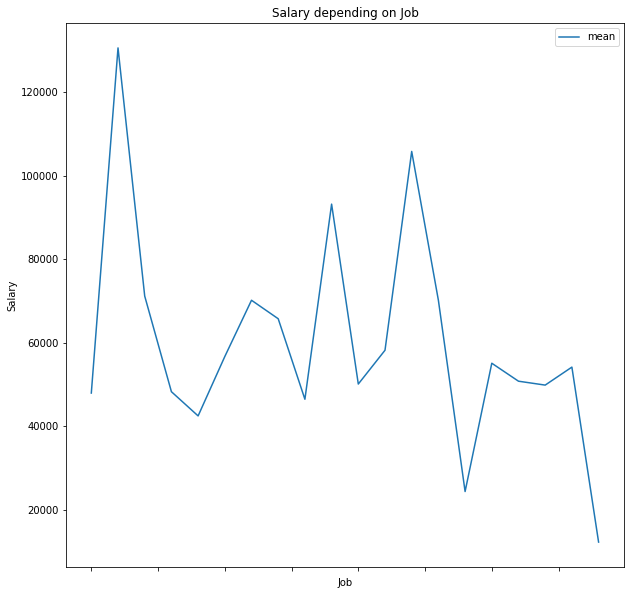

In [25]:
ax = SalaryVisual.groupby("Job").YearSalary.agg(['mean']).plot(figsize=(10,10),title="Salary depending on Job")
ax.set_ylabel("Salary")

Text(0,0.5,'Salary')

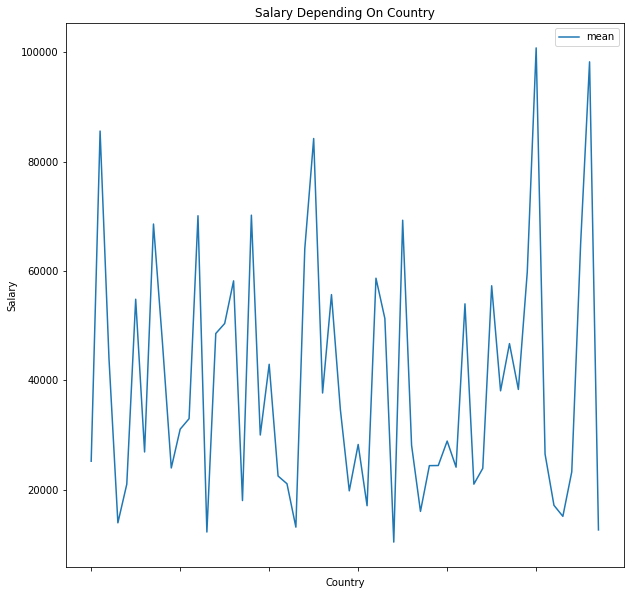

In [26]:
ax = SalaryVisual.groupby("Country").YearSalary.agg(['mean']).plot(figsize=(10,10),title="Salary Depending On Country")
ax.set_ylabel("Salary")

The above figures show the relationships between Job and YearlyCompensation, Country and YearlyCompensation. The average yearly compensation vary with these two variables.

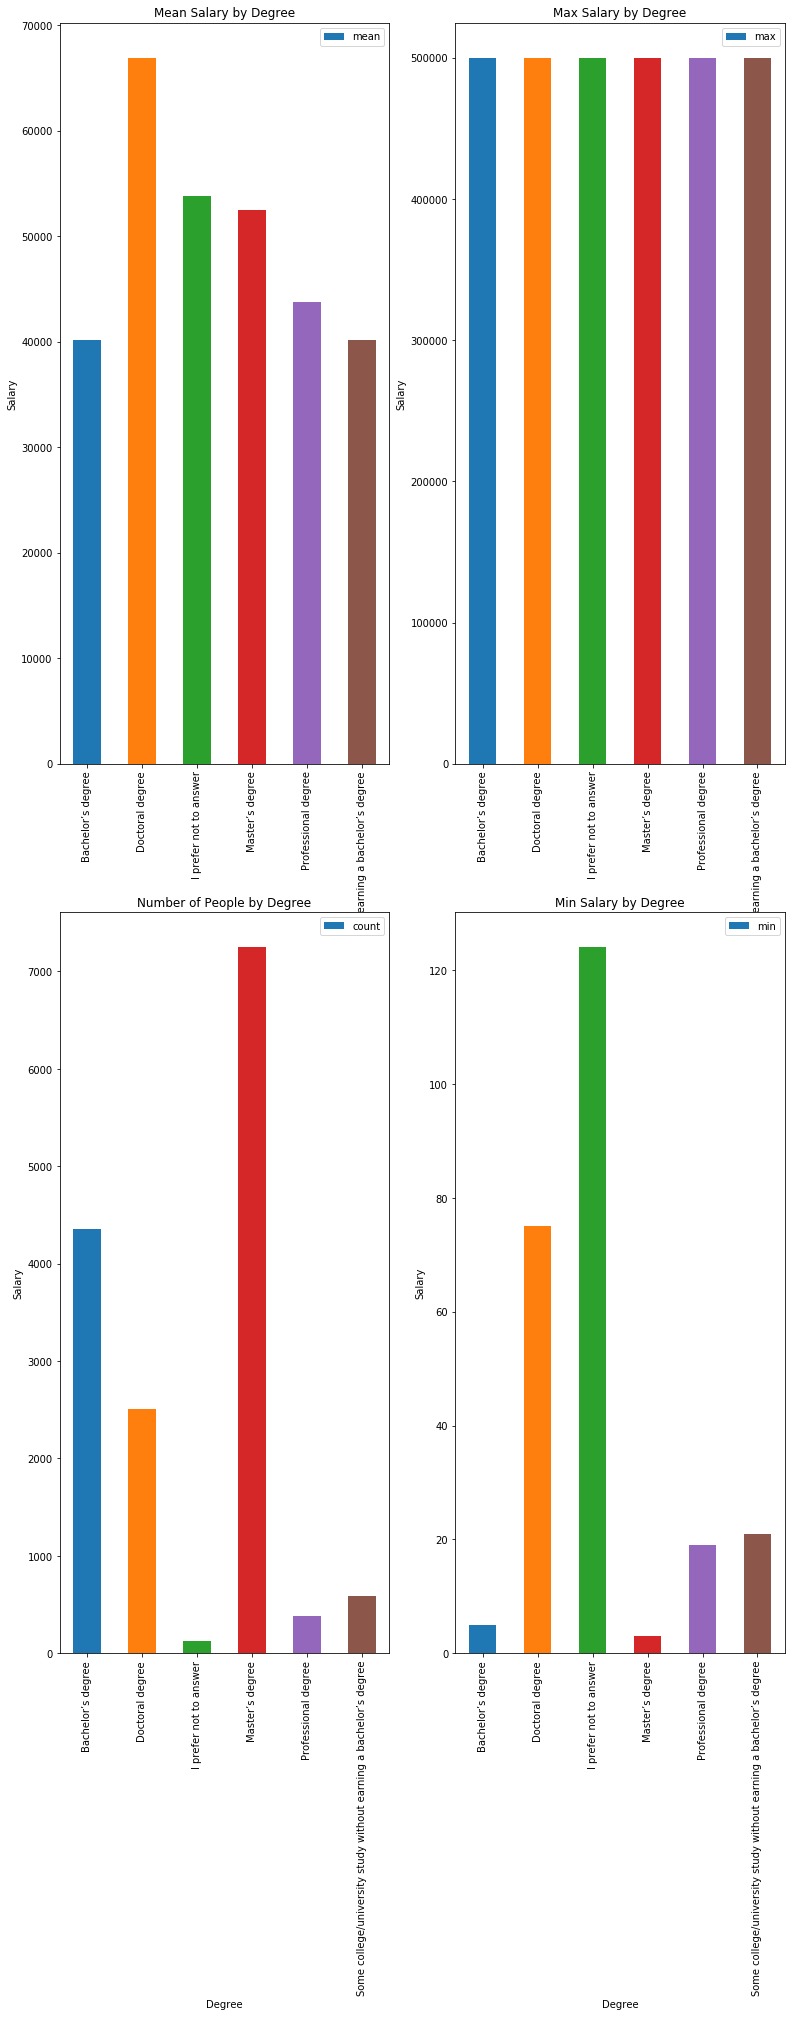

In [27]:
compensation_by_degree=SalaryVisual.groupby("Degree").YearSalary.agg(['count', 'mean', 'min', 'max'])
fig, axes = plt.subplots(nrows=2, ncols=2)
ax = compensation_by_degree.plot(y='mean',kind="bar",title="Mean Salary by Degree",ax=axes[0,0],figsize=(13,30))
ax.set_ylabel("Salary")
ax = compensation_by_degree.plot(y='max',kind="bar",title="Max Salary by Degree",ax=axes[0,1])
ax.set_ylabel("Salary")
ax = compensation_by_degree.plot(y='count',kind="bar",title="Number of People by Degree",ax=axes[1,0])
ax.set_ylabel("Salary")
ax = compensation_by_degree.plot(y='min',kind="bar",title="Min Salary by Degree",ax=axes[1,1])
ax.set_ylabel("Salary")
plt.show()

The above figure show the mean yearly compensation of people depending on their education degrees. It proves that people with higher degree earn more salary. The Doctoral degree has the highest average. It should be also noted that people with different degrees all have chance to earn salary as high as 500,000. Majority of people have master degree.
From the last figure that shows minimum compensation by degree, it shows that that some people earn as less as 20. This may be fake because some respondents may have given false response. 

Therefore, for further prediction, we will delete the data whose salary is lower than a threshold.

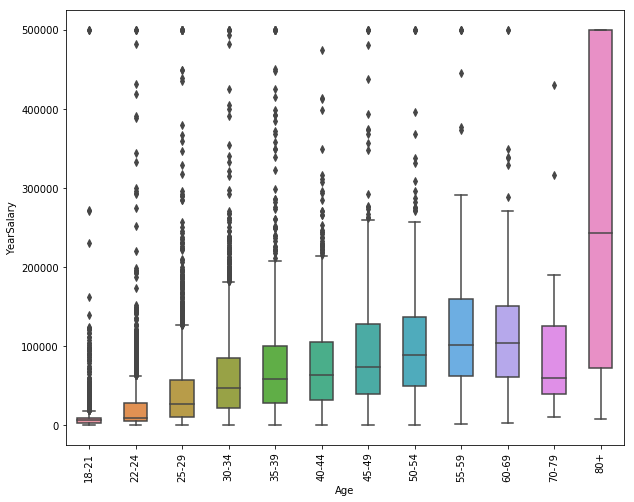

In [44]:
#box plot Age vs Salary
var = 'Age'
order=["18-21","22-24","25-29","30-34","35-39","40-44","45-49","50-54","55-59","60-69","70-79","80+"]
data = pd.concat([SalaryVisual['YearSalary'], SalaryVisual[var]], axis=1)
f, ax = plt.subplots(figsize=(10, 8))
fig = sns.boxplot(x=var, y="YearSalary", data=SalaryVisual,width=0.5,order=order)
_ = fig.set_xticklabels(fig.get_xticklabels(),rotation=90)

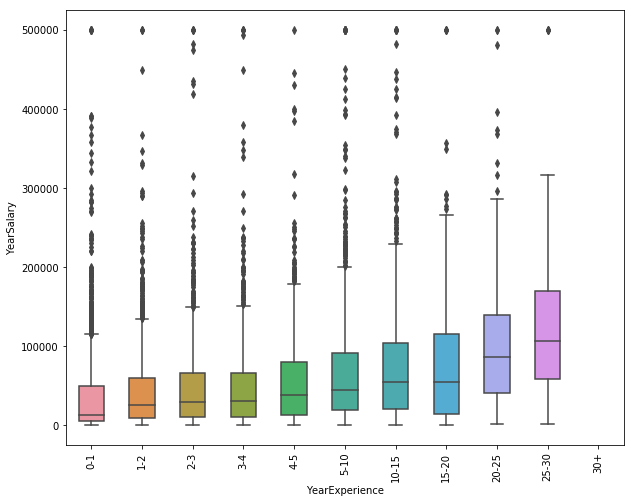

In [29]:
#box plot YearExperience vs yearly compensation
var = 'YearExperience'
order=["0-1","1-2","2-3","3-4","4-5","5-10","10-15","15-20","20-25","25-30","30+"]
data = pd.concat([SalaryVisual['YearSalary'], SalaryVisual[var]], axis=1)
f, ax = plt.subplots(figsize=(10, 8))
fig = sns.boxplot(x=var, y="YearSalary", data=SalaryVisual,width=0.5,order=order)
_ = fig.set_xticklabels(fig.get_xticklabels(),rotation=90)

The above figure shows the relationship between salary and work experience and the relationships between age and salary. Based on the figures, it can be concluded that older people or those who have longer work experience have a higher salary. Therefore we need to keep these two features for regression.

### Visualize the order of feature importance

Pearson is the most widely used correlation coefficient, which measures the linear association between continuous variables. In other words, this coefficient quantifies the degree to which a relationship between two variables can be described by a line. Here we use Pearson coefficient to measure the correlation between all the features in our dataset and plot correlation of features with YearlyCompensation.

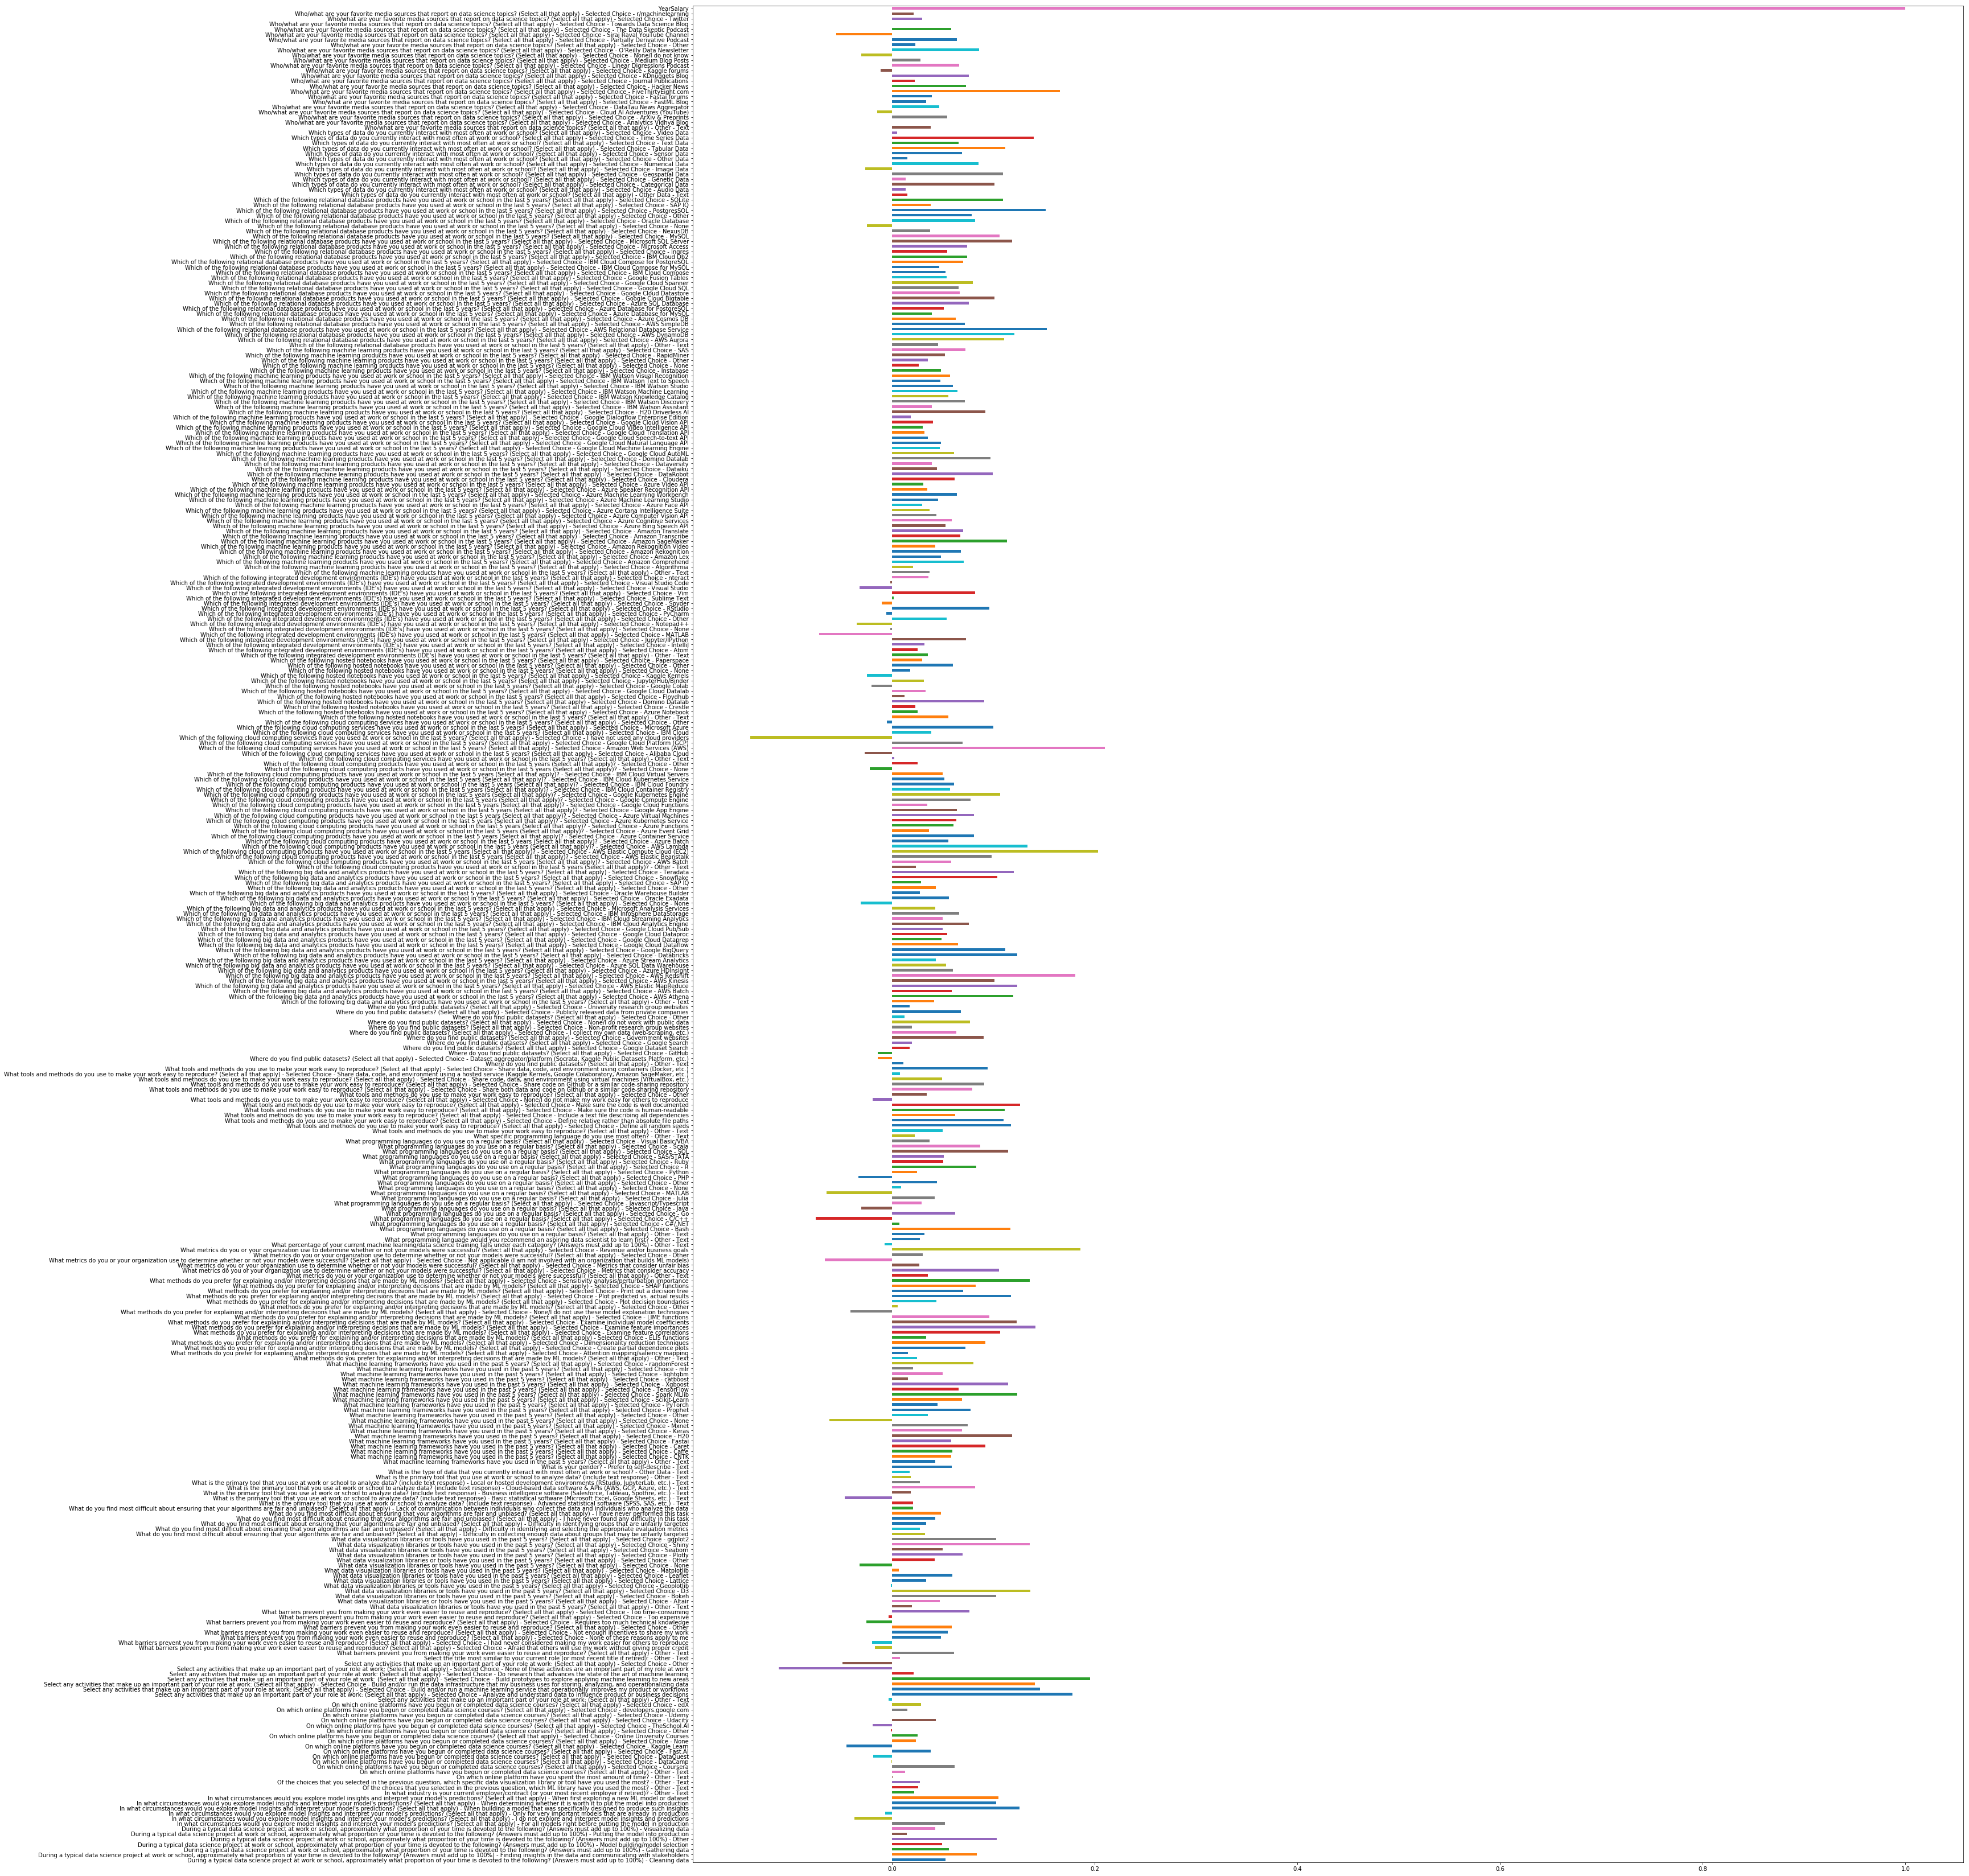

In [30]:
for column in SalaryVisual.columns:
    if len(SalaryVisual[col].value_counts())==1:
        SalaryVisual.drop([col], axis=1,inplace=True)

corr = SalaryVisual.corr()
(corr.YearSalary.sort_index().plot(kind="barh",figsize=(40,60)))

The computation of Pearson coefficient ensures that result will always fall between -1 and 1. The closer coeffient is to 1, the more an increase in one variable associates with an increase in salary. On the other hand, the closer coeffient is to -1, the increase in one variable would result in decrease in salary. If a certain variable and YearlyCompensation are independent, then the coefficient is close to 0. Therefore, we use the absolute value of pearson coefficient to measure the importance of this variable.

Text(0,0.5,'Absolute correlation with YearSalary')

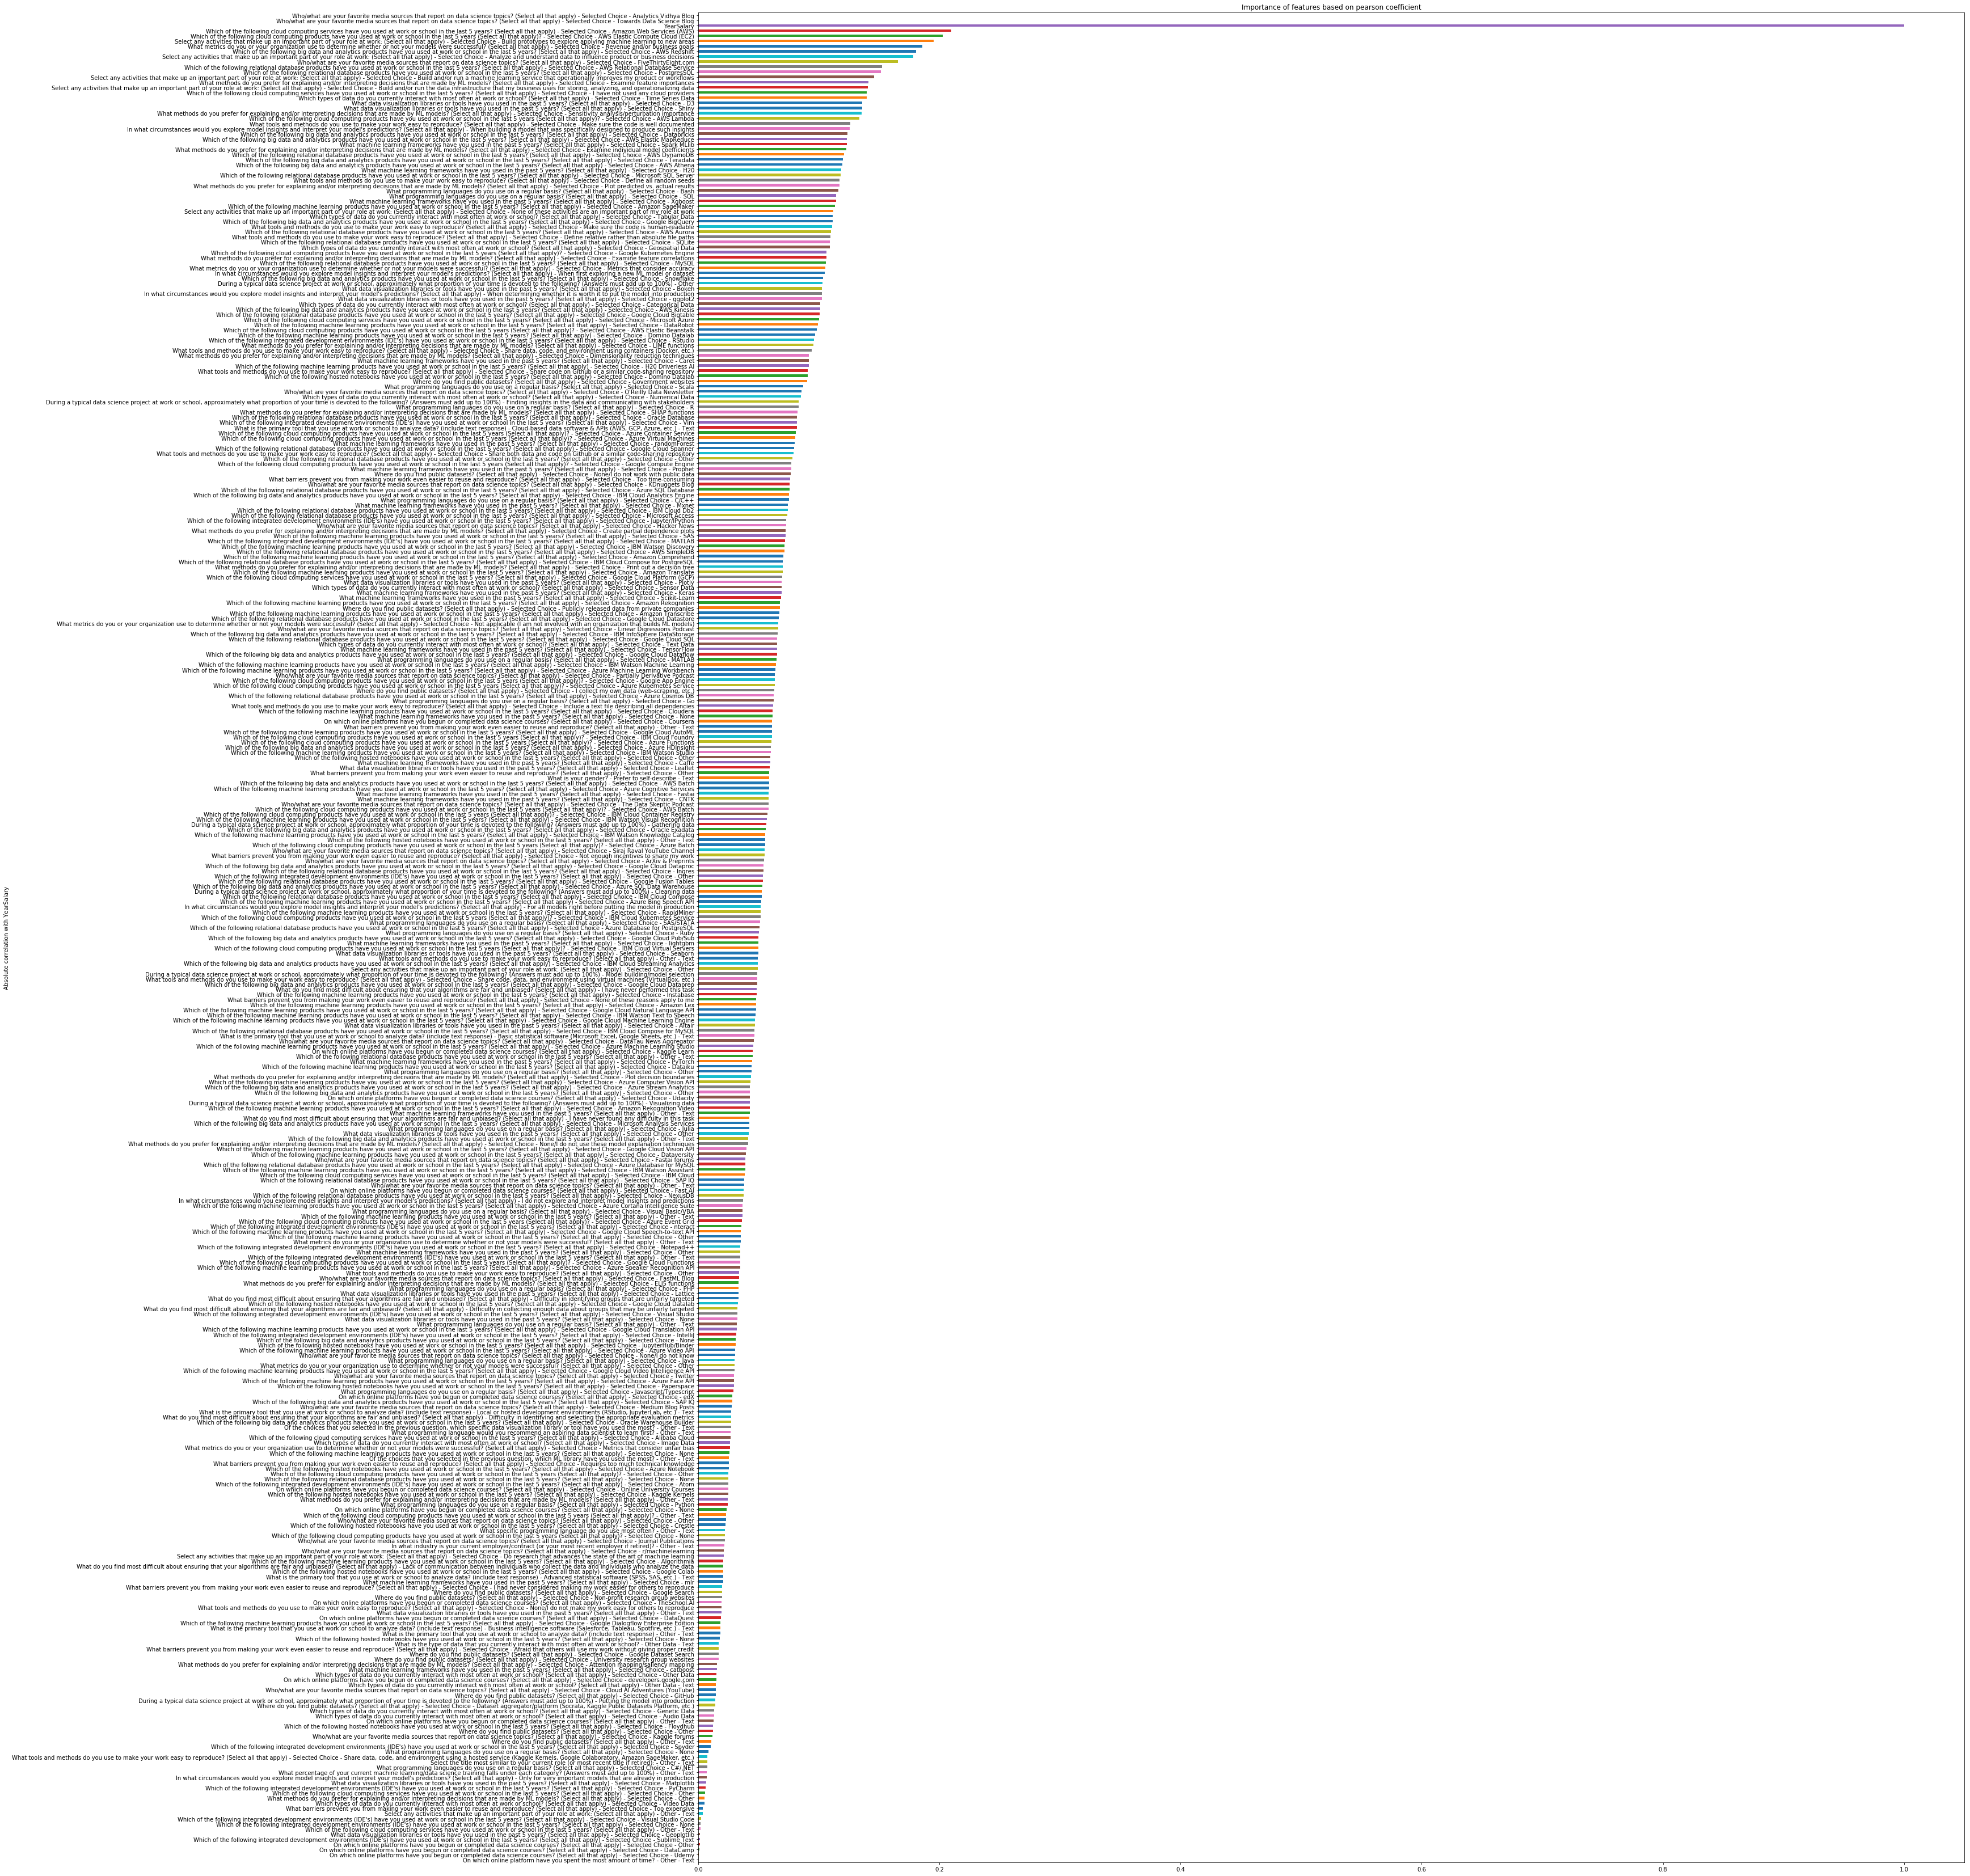

In [31]:
correlation = corr.YearSalary.apply(lambda x: abs(x)).sort_values()
ax = (correlation.plot(kind="barh",figsize=(40,60),title="Importance of features based on pearson coefficient"))
ax.set_ylabel('Absolute correlation with YearSalary')

In [32]:
print("TOP 5 most important features according to correlation with Salary:")
print(correlation.sort_values(ascending=False)[1:6],"\n")

print("TOP 5 less important features according to correlation with Salary:")
print(correlation.sort_values(ascending=False)[-5:])

TOP 5 most important features according to correlation with Salary:
Which of the following cloud computing services have you used at work or school in the last 5 years? (Select all that apply) - Selected Choice - Amazon Web Services (AWS)                   0.209691
Which of the following cloud computing products have you used at work or school in the last 5 years (Select all that apply)? - Selected Choice - AWS Elastic Compute Cloud (EC2)             0.203011
Select any activities that make up an important part of your role at work: (Select all that apply) - Selected Choice - Build prototypes to explore applying machine learning to new areas    0.195176
What metrics do you or your organization use to determine whether or not your models were successful? (Select all that apply) - Selected Choice - Revenue and/or business goals              0.185821
Which of the following big data and analytics products have you used at work or school in the last 5 years? (Select all that apply) - Select

We can learn from above that the top 5 most important features according to pearson coefficient with YearlyCompensation is:
1. Using AWS in the past
2. Using EC2 in the past
3. Building prototypes to explore applying machine learning to new areas in work
4. Using Revenue and/or business goals to determine wheter or not their model was successful
5. Using AWS Redshift product in the past

We can learn from above that the top 5 less important features according to pearson coefficient with YearlyCompensation is:
1. Completing Datacamp Data science course
2. Completing Udemy Data science course
3. Spending most of their other online platform
4. Towards Data Science Bog as their favorite media source
5. Analytics Vidhya Blog as their vaforite media source

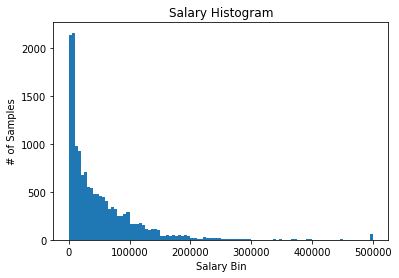

In [33]:
plt.hist(SalaryVisual['YearSalary'], bins=100)
plt.title("Salary Histogram")
plt.xlabel("Salary Bin")
plt.ylabel("# of Samples")
plt.show()

When we draw a histogram showing the distribution of yearly compensation, the number of persons keeps dropping from 0 to 300,000. There should be a concern that there is a minor peak at 500,000. There is a chance that some respondents just choose the largest value without any reason. 

In [34]:
#remove records that has salary above 350,000 or below 1,000.
for column in Salary.columns:
    if len(Salary[column].value_counts())==1:
        Salary.drop([column], axis=1,inplace=True)

Salary.drop(Salary[Salary.Yearly_compensation < 1000].index, inplace=True)
Salary.drop(Salary[Salary.Yearly_compensation > 350000].index, inplace=True)

In [35]:
for column in Salary.columns: 
    if Salary[column].isna().any():
        print(column)

for column in Salary.columns: 
    if isinstance(Salary.loc[1,column],str):
        print(column)

In [36]:
X = Salary.drop(['Yearly_compensation'],axis=1)
Y = Salary['Yearly_compensation']

from sklearn.model_selection import train_test_split
X_Tr, X_Te, Y_Tr, Y_Te = train_test_split(X,Y,test_size=0.3, random_state=20)

#### After cleaning data, we have data of size below:

In [38]:
print(X.shape,X_Tr.shape)

(13995, 605) (9796, 605)


# 3 Feature selection

##### Explain how feature engineering is a useful tool in machine learning.
Feature engineering is the process of using domain knowledge of the data to create features that make machine learning algorithms work better. If feature engineering is done correctly, it increases the predictive power of machine learning algorithms by creating features from raw data that help facilitate the machine learning process. Feature engineering can be valuable since we can isolate and highlight key information, which helps our algorithms "focus" on what’s important. We can also bring in our own domain expertise.

In [39]:
def feature_scaling(X_Tr, X_Te, method):
    methodmap = {'z-score':StandardScaler(),'min-max':MinMaxScaler(),'robust':RobustScaler()}
    if method not in ['z-score','min-max','robust']:
        print("We don't have this kind of method for normalization. Please choose from ['z-score','min-max','robust']")
        return pd.DataFrame(X_Tr), pd.DataFrame(X_Te)
    else:
        ss = methodmap[method].fit(X_Tr)
        X_Tr = ss.transform(X_Tr)
        X_Te = ss.transform(X_Te)
        return pd.DataFrame(X_Tr), pd.DataFrame(X_Te)

X_Train_All, X_Test_All = feature_scaling(X_Tr,X_Te,'z-score')

#### We design a function that could implement two feature selection methods "select from lasso model" and "PCA" and compare their performance to choose better feature set.

In [40]:
def feature_selection(X_Tr, X_Te, Y_Tr, method='pca', para=None):
    if method not in ['variance','pca','lassocv']:
        print("We don't have this kind of method for normalization. Please choose from ['pca','Lassocv']")
        return X_Tr, X_Te
    else:
        if  method=='lassocv':
            clf = LassoCV(cv=5)
            sfm = SelectFromModel(clf, threshold=0.25)
            sfm.fit(X_Tr, Y_Tr)
            X_Tr = sfm.transform(X_Tr)
            X_Te = sfm.transform(X_Te)
            return pd.DataFrame(X_Tr), pd.DataFrame(X_Te)
        else:
            Para = para if para else 200
            sel = PCA(n_components=Para).fit(X_Tr)
            X_Tr = sel.transform(X_Tr)
            X_Te = sel.transform(X_Te)
            return pd.DataFrame(X_Tr), pd.DataFrame(X_Te)


In [41]:
LX_Tr, LX_Te = feature_selection(X_Train_All,X_Test_All,Y_Tr,'lassocv')

#####  justification why I select feature selecion method from Lasso 
This method could return the non-zero coefficients from linear models penalized with L1 norm and I select Lasso considering its linear property and L1 regularization. It can help us to get an insight to the resulting coefficients of the features returned by lasso models to see which ones have a positive or negative relationship with the salary. By setting a threshold value, features whose importance is greater or equal are kept while the others are discarded.

In [42]:
PCA_Tr, PCA_Te = feature_selection(X_Train_All,X_Test_All,Y_Tr,'pca')

##### justification why I select the set of features
PCA tries to find the directions of most variation in the dataset. Since the dimension of our feature set is too large, using PCA I can identify what are the most important dimensions and just keep part of them to explain most of the variance we see in our data. I can  reduce the dimension of the data drastically. Moreover, it also enables us to identify what the most important variables in the original feature space are. Thus we use pca to extract top 200 high variance dimensions.

# 4. Model Implementation
#### I developed a class "Regressor" that could implement four different algorithms, which are "LinearRegression", "Lasso", "RandomForest", "GradientBoosting". In Q3, I obtained two bunches of features named "PCA" and "SelectLasso". So here we respectively apply four methods on two kinds of features to choose the better feature bunch. Then comparing the results on better features, I choose the best model.

In [43]:
from collections import OrderedDict

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

from sklearn.metrics import mean_squared_error, make_scorer, r2_score, mean_absolute_error
from sklearn.metrics import roc_auc_score, roc_curve, auc,confusion_matrix,accuracy_score

def bias(y_predict,y):
    y_predict = np.array(y_predict)
    y = np.array(y)
    avg = np.average(y_predict)
    return np.sqrt(np.average(np.power((avg-y),2)))
def variance(y_predict):
    y_predict = np.array(y_predict)
    return np.sqrt(np.var(y_predict))

def two_score(y_true,y_pred):    
    mean_squared_error(y_true,y_pred)
    score = r2_score(y_true,y_pred)
    return score

def run_kfold(model,X,y,folds=10):
    kf = KFold(n_splits=folds)
    kf.get_n_splits(X)
    score_keep = []
    trade_keep = []
    fold = 0
    print("The result with {}-fold cross-validation on training set".format(folds))

    for train_index, test_index in kf.split(X):
        fold += 1
        X_tr, X_te = X.iloc[train_index], X.iloc[test_index]
        y_tr, y_te = y.iloc[train_index], y.iloc[test_index]
        clf = model.fit(X_tr, y_tr)
        y_tr_predict = clf.predict(X_tr)
        y_te_predict = clf.predict(X_te)

        tr_r2 = r2_score(y_tr, y_tr_predict)
        tr_rootmeansquareerror = np.sqrt(mean_squared_error(y_tr, y_tr_predict))
        
        te_r2 = r2_score(y_te, y_te_predict)
        te_rootmeansquareerror = np.sqrt(mean_squared_error(y_te, y_te_predict))
        
        # print("Fold {} R2 training score: {}, testing score: {}".format(fold,train_r2,test_r2))
        # print("RMSE training score: {}, testing score: {}".format(train_rmse,test_rmse))
        tr_bias = bias(y_tr_predict,y_tr)
        tr_variance = variance(y_tr_predict)
        tr_total = tr_bias + tr_variance
        
        te_bias = bias(y_te_predict,y_tr)
        te_variance = variance(y_te_predict)
        te_total = te_bias + te_variance

        score_keep.append((tr_r2, te_r2,tr_rootmeansquareerror, te_rootmeansquareerror))
        trade_keep.append((tr_bias,te_bias,tr_variance,te_variance,tr_total,te_total))
    score_df = pd.DataFrame(score_keep, columns=["train_R2","test_R2","train_RMSE","test_RMSE"])
    trade_df = pd.DataFrame(trade_keep, columns=["train_bia","test_bia","train_var","test_var","train_total","test_total"])
    print(score_df.describe()[["test_R2","test_RMSE"]][1:4])
    return clf, score_df, trade_df

class Regressor(object):
    def __init__(self,train_data,train_targets):
        super().__init__()
        self.train_data = train_data
        self.train_targets = train_targets
        randomforesthyperparameters = {'n_estimators': list(range(85,120,5)),'max_depth': list(range(45,60,3)),'min_samples_leaf': [1, 2, 3]}
        gradientboostinghyperparameters = {'n_estimators': list(range(90,120,5)),'max_depth': list(range(4,15,3)),'min_samples_leaf': [1, 2]}
        self.models=OrderedDict([('LinearRegression',[LinearRegression(),None]),\
                            ('Lasso',[Lasso(alpha=9.0,max_iter=2000,random_state=20),dict(alpha=np.arange(5,15,0.5))]),\
                            ('RandomForest',[RandomForestRegressor(n_estimators = 105, max_depth=40, min_samples_leaf=2),randomforesthyperparameters]),\
                            ('GradientBoosting',[GradientBoostingRegressor(),gradientboostinghyperparameters])])
        #1.1 and 2.70 # ElasticNet(alpha=1.0, l1_ratio=0.5）
    def train_model(self,model_name,scorer="R2",ifhyper_tune=False,hyper_paras="",folder=10):
        self.model_name = model_name
        model = self.models[model_name][0]
        if ifhyper_tune:
            if not hyper_paras:
                hyper_paras = self.models[model_name][1]
            # Grid search method for hyper-parameter tuning in which we use 5-fold cross validation
            if hyper_paras:
                if scorer=='R2':
                    acc_scorer = make_scorer(r2_score)
                elif scorer == 'RMSE':
                    acc_scorer = make_scorer(mean_squared_error)
                else:
                    acc_scorer = make_scorer(two_score, greater_is_better=True)
                grid = GridSearchCV(model, hyper_paras, cv=5, scoring=acc_scorer, n_jobs=-1) 

                grid.fit(self.train_data, self.train_targets)
                print('The best score of model {} through {}-cross validation is {}, with the best hyper-parameter {}\n'\
                    .format(model_name, 5, grid.best_score_, grid.best_params_))

                # Best model
                best_model = grid.best_estimator_
            else:
                best_model = model.fit(self.train_data,self.train_targets)
            train_pred = best_model.predict(self.train_data)
            R2 = r2_score(self.train_targets,train_pred)
            print('Through Hypertuning on {}, we get the best model and the results below:'.format(model_name))
            print('The R2 score is {}'.format(R2))
            RMSE = np.sqrt(mean_squared_error(self.train_targets,train_pred))
            print('The RMSE score is {}'.format(RMSE))
            score_df = pd.DataFrame([(R2,RMSE)], columns=["R2", "RMSE"])
        else:
            best_model, score_df, trade_df = run_kfold(model,self.train_data,self.train_targets,folder)
        
        self.best_model = best_model
        if ifhyper_tune:
            return best_model, score_df
        else:
            return best_model, score_df, trade_df

    def test_model(self,test_data,test_targets,new_best=None):
        if new_best is not None:
            test_pred = new_best.predict(test_data)
        else:
            test_pred = self.best_model.predict(test_data)
            print("Result of Model {} is list below:".format(self.model_name))
        R2 = r2_score(test_targets, test_pred)
        RMSE = np.sqrt(mean_squared_error(test_targets,test_pred))
        BIAS = bias(test_pred,test_targets)
        VAR = variance(test_pred)
        TOTAL = BIAS + VAR
        # test accuracy
        print('R2 score is {}'.format(R2))
        print('RMSE socre is {}'.format(RMSE))
        # print('Bias score is {}'.format(BIAS))
        # print('Variance score is {}'.format(VAR))
        # print('Bias+Variance score is {}'.format(TOTAL))
        return R2, RMSE, BIAS, VAR, TOTAL

### LinearRegression
It is a technique for predicting a dependent variable based on one or more independent variables. It tries to fit a straight line to the response variable data so that the line minimizes the squared differences (also called errors or residuals) between the actual obbserved response and the predicted point on the line. 

Pros: It can work on any size of dataset and can give about the relevance of variables.

Cons: It assumes that independent variables have linear relationship with dependent variable, which is always not true in real life. 

Why use it? We assume that most of the features are linearly related with 'YearlyCompensation' and it's a classic regression model so we use it.

### Lasso Regression

It is similar to LinearRegression in that it also models data as a linear combination of explanatory variables. The difference is that it adds l1 regularizer to objective functions and tries to fit a straight line to the response variable data so that the line minimizes errors between the actual obbserved response and the predicted point on the line.

pros: It can work on any size of dataset and can give about the relevance of variables. It uses l1 regularizer that encourages sparsity and works as a feature selector. 

cons: It assumes that independent variables have linear relationship with dependent variable, which is always not true in real life. 

Why use it? We assume that most of the features are linearly related with 'YearlyCompensation' and adding regularization can prevent overfitting.

### Random Forest

It is a versatile algorithm and can be used for both regression and classification. It improves over the top of the decision tree algorithm and tries to generate multiple small decision trees from random subsets of the data. Then it combines the results from each of the decision tree to give the final unbiased prediction.

pros: It works well on large datasets and can be used to extract variable importance. It does not require feature engineering (scaling and normalization). 

cons:It would overfit in case 

why use it? It's one of the most accurate prediction model and Random forests have successfully been implemented in a variety of fields. SO we choose it.

### Gradient Boosting Decision Tree

It is similar to Random Forests that generate multiple trees. Differently, Random Forest trains each tree independently while GBTs build trees one at a time, where each new tree helps to correct errors made by previously trained tree.

pros: it often provides predictive accuracy that cannot be beat and has lots of flexibility about loss functions. It doesn't require data pre-processing and can handle missing data.

cons: It require careful tuning of the learning rate and other parameters. And the training process can require a lot of computation.

Why use it?
It's one of the most accurate prediction model and has successfully been implemented in a variety of fields. The building trees strategy is different from RandomForest so we choose it.

### Implement different regression algorithms of your choice on the training data using 10-fold cross-validation.

#### Model implementation with Features from PCA

In [103]:
PcaFeatureReg = Regressor(PCA_Tr,Y_Tr)

In [104]:
print('Result from LinearRegression:')
plr_model, plr_score, plr_trade = PcaFeatureReg.train_model('LinearRegression')

print('\nResult from RandomForest:')
prfr_model, prfr_score, prfr_trade = PcaFeatureReg.train_model('RandomForest')

print('\nResult from GradientBoosting:')
pgdb_model, pgdb_score, pgdb_trade = PcaFeatureReg.train_model('GradientBoosting')

print('\nResult from Lasso:')
plasso_model, plasso_score, plasso_trade = PcaFeatureReg.train_model('Lasso')

Result from LinearRegression:
The result with 10-fold cross-validation on training set
       test_R2     test_RMSE
mean  0.508192  36259.826012
std   0.027380   1579.884032
min   0.478356  33770.875354

Result from RandomForest:
The result with 10-fold cross-validation on training set
       test_R2     test_RMSE
mean  0.334685  42181.731911
std   0.023800   1575.981512
min   0.298674  40849.660778

Result from GradientBoosting:
The result with 10-fold cross-validation on training set
       test_R2     test_RMSE
mean  0.391928  40332.249468
std   0.023216   1724.637323
min   0.358774  38388.422361

Result from Lasso:
The result with 10-fold cross-validation on training set
       test_R2     test_RMSE
mean  0.508335  36254.577446
std   0.027380   1580.250618
min   0.478435  33763.873561


#### Model implementation with Features from LassoSelection

In [105]:
LeFeatureReg = Regressor(LX_Tr,Y_Tr)

In [106]:
print('Result from LinearRegression:')
lr_model, lr_score, lr_trade = LeFeatureReg.train_model('LinearRegression')

print('\nResult from Lasso:')
lasso_model, lasso_score,lasso_trade = LeFeatureReg.train_model('Lasso')

print('\nResult from RandomForest:')
rfr_model, rfr_score, rfr_trade = LeFeatureReg.train_model('RandomForest')

print('\nResult from GradientBoosting:')
gdb_model, gdb_score, gdb_trade = LeFeatureReg.train_model('GradientBoosting')

Result from LinearRegression:
The result with 10-fold cross-validation on training set
       test_R2     test_RMSE
mean  0.585748  33281.988989
std   0.020902   1432.597005
min   0.558525  31677.198209

Result from Lasso:
The result with 10-fold cross-validation on training set
       test_R2     test_RMSE
mean  0.585777  33280.844648
std   0.021063   1441.114786
min   0.557135  31674.508148

Result from RandomForest:
The result with 10-fold cross-validation on training set
       test_R2     test_RMSE
mean  0.580787  33479.506408
std   0.029581   1790.835260
min   0.505040  31555.613904

Result from GradientBoosting:
The result with 10-fold cross-validation on training set
       test_R2     test_RMSE
mean  0.582955  33394.714399
std   0.025714   1665.112675
min   0.531410  31364.495442


#### Choose better Features
To choose better features, we compute the R-Squre(R2) and Root Mean Square Error of model on testing set. Note that during the training, we do 10-fold cross-validation and the testing scores are the mean of 10 folds. 

Linear Regression: 
            
            Select from Lasso Model: R2: 0.585748 RMSE: 33281.988989
            PCA Selection: R2: 0.508192   RMSE: 36259.826012

Lasso Regression:

            Select from Lasso Model: R2: 0.585777 RMSE: 33280.844648
            PCA Selection: R2: 0.508335  RMSE: 36254.577446

Random Forest:

            Select from Lasso Model: R2: 0.580787  RMSE: 33479.506408
            PCA Selection: R2: 0.334685  RMSE: 42181.731911

Gradient Boosting:

            Select from Lasso Model: R2: 0.582955  RMSE: 33394.714399
            PCA Selection: R2: 0.391928  RMSE: 40332.249468


From the test performance, we can see that Feature Selection from Lasso is better than PCA. Therefore, in the following steps, we only use Feature Selection from Lasso Model.



To choose the best model across the folds, we compare its average and variance of accuracy for folds. Here we use R-Squre(R2) and Root Mean Square Error (RMSE to measure the accuracy.

Linear Regression: R2 Mean:0.585748 R2 Variance:0.020902

                   RMSE Mean: 33281.988989 Variance:1432.597005
                   
Lasso: R2 Mean:0.585777 R2 Variance:0.021063

       RMSE Mean: 33280.84464  Variance:1441.114786

Random Forest: R2 Mean:0.580787 R2 Variance:0.029581

               RMSE Mean: 33479.506408 Variance:1790.835260

Gradient Boosting: R2 Mean:0.582955  Variance:0.025714 

                   RMSE Mean:33394.714399 Variance: 1665.112675

R2 value and RMSE score are almost the same across different algorithms. Lasso has the best R2 score and RMSE score. 

To better view the distribution of scores of different algorithms, we visualize the score using boxplot. We also compute the bias-variance across the algorithms.

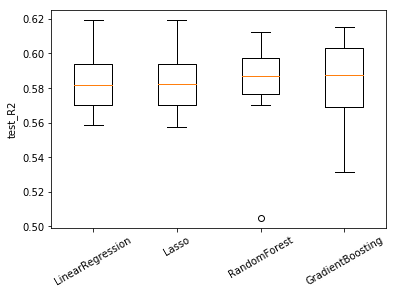

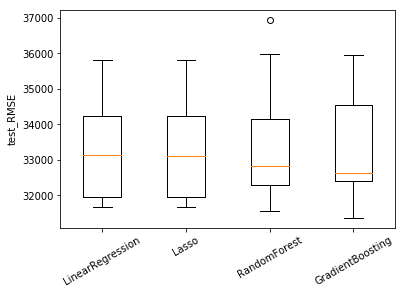

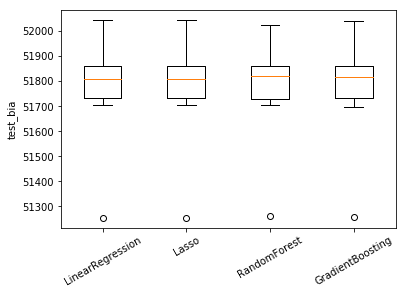

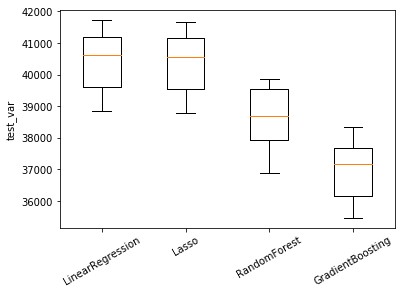

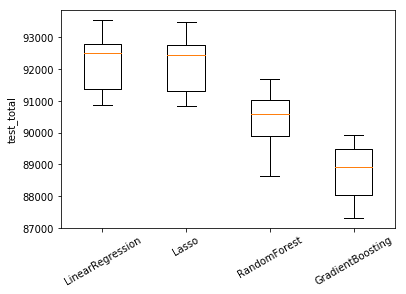

In [110]:
all_score = [lr_score,lasso_score,rfr_score,gdb_score]
xlabels = ['LinearRegression','Lasso','RandomForest','GradientBoosting']
ylabels = all_score[0].columns
for i in range(len(ylabels)):
    if not i%2:
        continue
    score = [j.iloc[:,i] for j in all_score]
    plt.figure()
    plt.ylabel(ylabels[i])
    plt.boxplot(score, labels=xlabels)
    plt.xticks(rotation=30)
    plt.show()
all_trade = [lr_trade,lasso_trade,rfr_trade,gdb_trade]
ylabels = all_trade[0].columns
for i in range(len(ylabels)):
    if not i%2:
        continue
    score = [j.iloc[:,i] for j in all_trade]
    plt.figure()
    plt.ylabel(ylabels[i])
    plt.boxplot(score, labels=xlabels)
    plt.xticks(rotation=30)
    plt.show()

From the above figures, we can see that there isn't much difference in R2, RMSE across the algorithms. We then check how bias-variance score across different algorithms.

Bias-variance tradeoff is the problem of simultaneously minimizing two sources of error that prevent supervised learning algorithms from generalizing beyond their training set:
- Bias is error from erroneous assumptions in the learning algorithm, high bias can cause an algorithm to miss the relevant relations between features and target outputs (underfitting)
- Variance is error from sensitivity to small fluctuations in the training set, high variance can cause overfitting, i.e., modelling the random noise in the training data, rather than the intended outputs

According to above figures, we can see that the bias of five algorithms are almost the same, but the variance are quite different. LinearRegression and Lasso have the larger variance, while RandomForest have lower and GradientBoosting have even lower variance. That's because GradientBoosting is based on weak learners (high bias, low variance).In terms of decision trees, weak learners are shallow trees, sometimes even as small as decision stumps (trees with two leaves). Boosting reduces error mainly by reducing bias. Taking into account that GradientBoosting performs better than RandomForest with regard to variance, we choose GradientBoosting as our best model.

# 5. Model Tuning

#### we use GridSearch Cross-Validation to tune the hyperparameters. 
1. For each algorithm, we define the hyperparameter space beforehand.
2. With every candidate hyperparameter, GridSearchCV will first split the data into K folds, train the model on K-1 folds only and then score on test data. We choose to use R2 as performance measure score. R2 measures how well the regression line approximates the real data points, it also portrays percent of variance in the data explained by regression model.
3. GridSearchCV will give the best hyperparameters based on the average R2 score.

In [111]:
lr_bestmodel, lr_bestscore = LeFeatureReg.train_model('LinearRegression',ifhyper_tune=True)

Through Hypertuning on LinearRegression, we get the best model and the results below:
The R2 score is 0.609853710186478
The RMSE score is 32337.127780446466


In [112]:
lasso_bestmodel, lasso_bestscore = LeFeatureReg.train_model('Lasso',ifhyper_tune=True)

The best score of model Lasso through 5-cross validation is 0.5843448336186001, with the best hyper-parameter {'alpha': 14.5}

Through Hypertuning on Lasso, we get the best model and the results below:
The R2 score is 0.6098225088872024
The RMSE score is 32338.42080854421


In [113]:
rfr_bestmodel, rfr_bestscore = LeFeatureReg.train_model('RandomForest',ifhyper_tune=True)

The best score of model RandomForest through 5-cross validation is 0.5801446959498213, with the best hyper-parameter {'max_depth': 51, 'min_samples_leaf': 3, 'n_estimators': 105}

Through Hypertuning on RandomForest, we get the best model and the results below:
The R2 score is 0.8572345142129361
The RMSE score is 19561.372166498768


In [114]:
gdb_bestmodel, gdb_bestscore = LeFeatureReg.train_model('GradientBoosting',ifhyper_tune=True)

The best score of model GradientBoosting through 5-cross validation is 0.5944514057552795, with the best hyper-parameter {'max_depth': 7, 'min_samples_leaf': 2, 'n_estimators': 105}

Through Hypertuning on GradientBoosting, we get the best model and the results below:
The R2 score is 0.8418056768144748
The RMSE score is 20591.270770822768


we list each algorithm's performance based on the  training set.

| Algorithm         |R2       |RMSE        |
|---                |---      |---         | 
|LinearRegression   |0.609854 |32337.127780|
|Lasso              |0.609823 |32338.420809|
|RandomForest       |0.857235 |19561.372166|
|GradientBoosting   |0.841806 |20591.270771|

According to above table, the models that perform better are RandomForest and GradientBoosting. RandomForest seems to be better. However, according to the analysis before, GradientBoosting has much lower variance than RandomForest and the bias are almost the same. 
### So we choose GradientBoosting as our best model.

# 6. Testing & Discussion


For optimal model, Gradient Boosting, I have listed the R2 results based on training and test.

In [117]:
print("The training results of best model is listed:")
gdb_besttrn_result = LeFeatureReg.test_model(LX_Tr,Y_Tr,gdb_bestmodel)
print("The testing results of best model is listed:")
gdb_besttst_result = LeFeatureReg.test_model(LX_Te,Y_Te,gdb_bestmodel)

For optimal model, GradientBoosting:
The training results of best model is listed:
R2 score is 0.8418056768144748
RMSE socre is 20591.270770822768
The testing results of best model is listed:
R2 score is 0.6225672928598104
RMSE socre is 31562.426438139693


In [116]:
print(gdb_besttrn_result,gdb_besttst_result)

(0.8418056768144748, 20591.270770822768, 51771.136888065754, 43157.70476183253, 94928.84164989828) (0.6225672928598104, 31562.426438139693, 51377.11390583564, 40938.415630326344, 92315.52953616198)



Below is the result obtained by applying model on training set and testing set.

|Measurement        |Train       |Test        |
|---                |---         |---         |
|R2                 |0.841805    |0.622567    |
|RMSE               |20591.270   |31562.426438|
|Bias               |51771.136   |51377.113905|
|Variance           |43157.7047  |40938.415630|
|Total              |94928.84164 |92315.529536|

From every perspective, the performance on training set is better than that on testing set.

Overfitting occurs when the model fits the data too well. Specifically, overfitting occurs if the model shows low bias but high variance which is often a result of an excessively complicated model. For underfitting, it occurs when the machine learning model cannot capture the underlying trend of the data. In other words, it happens when the model does not fit the data well enough. If the model or algorithm shows low variance but high bias, underfitting occurs. It is often the result of an excessively simple model.

In our case, our model is overfitting. First we can see the R2 score is much higher for training set than testing set, which means that the model fits training set so well. Comparing the Bias and variance between training set and testing set, variance difference between training set and testing set is much higher than bias difference. The variance in training stage is higher thatn test stage. In total we can conclude that the model is overfitting.

To improve the testing performance, we can fit multiple models and use cross-validation to compare its predictive accuracy on test data. In the case of GradientBoosting, the maximum tree depth also plays a huge role in determining the fit, so we can decrease the max depth to significantly reduces overfitting.